# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [8]:
# import libraries
import nltk
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import pickle
import unittest
import string
nltk.download(['punkt', 'wordnet'])
from nltk.tokenize import word_tokenize, RegexpTokenizer,sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
import pandas as pd
from sqlalchemy import create_engine
import re
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterDatabase.db')
df = pd.read_sql_table('messages', engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df['message']
y = df[df.columns[5:]]
added = pd.get_dummies(df[['related','genre']])
Y = pd.concat([y, added], axis=1)

### 2. Write a tokenization function to process your text data

In [4]:
print(X[0])

Weather update - a cold front from Cuba that could pass over Haiti


In [5]:
def tokenize(text):
    table = text.maketrans(dict.fromkeys(string.punctuation))
    words = word_tokenize(text.lower().strip().translate(table))
    words = [word for word in words if word not in stopwords.words('english')]
    lemmed = [WordNetLemmatizer().lemmatize(word) for word in words]
    lemmed = [WordNetLemmatizer().lemmatize(word, pos='v') for word in lemmed]
    stemmed = [PorterStemmer().stem(word) for word in lemmed]
    
    return stemmed

In [6]:
tokenize(X[0])

['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pa', 'haiti']

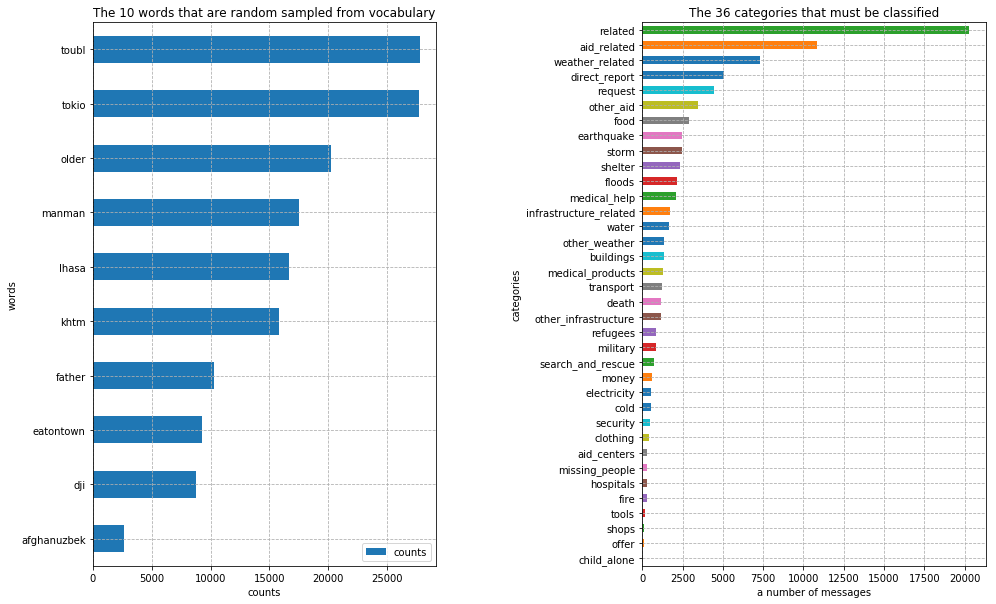

In [13]:
categories = df.columns[4:]

# Check vocabulary
vect = CountVectorizer(tokenizer=tokenize)
X_vectorized = vect.fit_transform(X)


# Convert vocabulary into pandas.dataframe
keys, values = [], []
for k, v in vect.vocabulary_.items():
    keys.append(k)
    values.append(v)

vocabulary = pd.DataFrame.from_dict({'words': keys, 'counts': values})


plt.figure(figsize=(16, 10))
plt.subplots_adjust(wspace=0.6)

ax1 = plt.subplot(1, 2, 1)
vocabulary.sample(30, random_state=72).sort_values('counts').plot.barh(x='words', y='counts', ax=ax1, colormap='tab10')
plt.title('The 30 words that are random sampled from vocabulary')
plt.xlabel('counts')
plt.grid(linestyle='dashed')

ax2 = plt.subplot(1, 2, 2)
df[categories].sum().sort_values().plot.barh(ax=ax2)
plt.title('The 36 categories that must be classified')
plt.ylabel('categories')
plt.xlabel('a number of messages')
plt.grid(linestyle='dashed')

plt.show()

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [8]:
# Create pipeline with Classifier
model=MultiOutputClassifier(RandomForestClassifier())
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', model)
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
# split data, train and predict
X_train, X_test, y_train, y_test = train_test_split(X, Y);
pipeline.fit(X_train.as_matrix(), y_train.as_matrix());
y_pred = pipeline.predict(X_test);

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [10]:
# Get results and add them to a dataframe.
def get_results(y_test, y_pred):
    results = pd.DataFrame(columns=['Category', 'f_score', 'precision', 'recall'])
    num = 0
    for cat in y_test.columns:
        precision, recall, f_score, support = precision_recall_fscore_support(y_test[cat], y_pred[:,num], average='weighted')
        results.set_value(num+1, 'Category', cat)
        results.set_value(num+1, 'f_score', f_score)
        results.set_value(num+1, 'precision', precision)
        results.set_value(num+1, 'recall', recall)
        num += 1
    print('Aggregated f_score:', results['f_score'].mean())
    print('Aggregated precision:', results['precision'].mean())
    print('Aggregated recall:', results['recall'].mean())
    return results

In [11]:
results = get_results(y_test, y_pred)
results

Aggregated f_score: 0.933826394801
Aggregated precision: 0.935338743458
Aggregated recall: 0.944848712472


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and

,Category,f_score,precision,recall
1,request,0.873832,0.882213,0.887855
2,offer,0.994511,0.99269,0.996338
3,aid_related,0.746533,0.752597,0.752365
4,medical_help,0.902057,0.903595,0.925084
5,medical_products,0.93623,0.93704,0.953006
6,search_and_rescue,0.961237,0.962081,0.972994
7,security,0.976639,0.984531,0.984284
8,military,0.954824,0.956991,0.967653
9,child_alone,1,1,1
10,water,0.944081,0.952058,0.953921


### 6. Improve your model
Use grid search to find better parameters. 

In [53]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7fe3a1c0b488>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None,

In [13]:
parameters = {'clf__estimator__max_depth': [10, None],
              'clf__estimator__min_samples_leaf':[2, 5]}

cv = GridSearchCV(pipeline, parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [18]:
cv.fit(X_train.values, y_train.values)
y_pred = cv.predict(X_test)
results_optimum = get_results(y_test, y_pred)
results_optimum

Aggregated f_score: 0.931209383531
Aggregated precision: 0.934732295386
Aggregated recall: 0.944457485349


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and

,Category,f_score,precision,recall
1,request,0.855868,0.875921,0.877937
2,offer,0.994511,0.99269,0.996338
3,aid_related,0.763279,0.762969,0.763808
4,medical_help,0.894239,0.896923,0.923253
5,medical_products,0.937326,0.943001,0.954379
6,search_and_rescue,0.9602,0.973868,0.973146
7,security,0.976261,0.968515,0.984132
8,military,0.954003,0.961761,0.967958
9,child_alone,1,1,1
10,water,0.915202,0.936233,0.938816


In [19]:
cv.best_estimator_

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
model=MultiOutputClassifier(DecisionTreeClassifier())                         
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', model)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline.fit(X_train.as_matrix(), y_train.as_matrix())
y_pred = pipeline.predict(X_test)

In [11]:
results_DT = get_results(y_test, y_pred)
results_DT

Aggregated f_score: 0.936109616014
Aggregated precision: 0.934731173914
Aggregated recall: 0.937708705698


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,Category,f_score,precision,recall
1,request,0.851802,0.850082,0.85383
2,offer,0.990624,0.98843,0.992829
3,aid_related,0.717746,0.717259,0.718798
4,medical_help,0.9009,0.898361,0.903723
5,medical_products,0.94119,0.939757,0.942783
6,search_and_rescue,0.960712,0.960486,0.96094
7,security,0.966706,0.964919,0.968569
8,military,0.960438,0.958964,0.962161
9,child_alone,1,1,1
10,water,0.954077,0.954578,0.953616


### 9. Export your model as a pickle file

In [12]:
pickle.dump(cv, open('model.pkl', 'wb'))

NameError: name 'cv' is not defined

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.